# <center>Assignment 3</center>
## <center>Name: Abdullah Maksud Vadhariya</center>
## <center>Ub Id: 50374344</center>

In [218]:
# Imports
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Stock Trading Environment 

In [219]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing whether the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path  # Path of the CSV file containing the historical stock data.
        self.stock_data = pd.read_csv(self.file_path)  # Reading the CSV file containing the historical stock data.
        self.train = train  # Boolean indicating to use the training stock data by default.
        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()
        self.observation_space = spaces.Discrete(4)  # This defines that there are four states in the environment.
        # This defines that there are 3 discrete actions that the agent can perform (Buy, Sell, Hold).
        self.action_space = spaces.Discrete(3)
        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)"""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector that will be passed to the agent.
            observation = [price_increase, price_decrease, 0, 1]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, 0, 1]
        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        return observation

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - (Integer in the range 0 to 2 inclusive.)

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)
                 reward: - (Integer/Float value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = 1
            stock_not_held = 0
        else:
            stock_held = 0
            stock_not_held = 1

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the number of infected people becomes greater than 75 % of the population.
        done = True if (self.timestep >= self.max_timesteps) \
            else False

        info = {}
        return observation, reward, done, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

### The Q-learning algorithm 

In [220]:
# Implementing Q-Learning for the stock trading environment.
class QLearning:
    """This class implements the Q-learning algorithm."""

    def __init__(self, environment):
        """This method instantiates the Q-learning parameters.

        :param environment: - This is the environment which needs to be solved."""

        self.environment = environment        
        self.Q_Table = np.zeros((self.environment.observation_space.n,self.environment.action_space.n))
        self.episodes = 1000
        self.epsilon_list, self.rewards_list= [], []
        self.max_epsilon,self.epsilon = 1, 1
        self.min_epsilon = 0.01        
        self.epsilon_decay_rate = 0.002        
        self.actions = [0,1,2]        
        self.gamma = 0.95
        self.learn_rate = 0.002

    def train(self):
        """This method performs the agent training."""
        
        for episode in range (self.episodes):

          # Resetting Env for ech episode
          state = self.environment.reset()
          done = False
          rewards_per_episode = 0

          while not done:            
            # Epsilon which Explore Rate Decay over the steps of episode
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay_rate * episode)
            
            # To explore or explot depending on random value generated compared with epsilon
            action = np.argmax(self.Q_Table[state,:]) if self.epsilon <= np.random.rand() else np.random.choice(self.actions)
            
            new_state, new_reward, done, info = self.environment.step(action)  

            # Bellman Equation Q Value Update
            self.Q_Table[state, action] = self.Q_Table[state,action]+self.learn_rate * (new_reward + self.gamma * np.max(self.Q_Table[new_state,:]) - self.Q_Table[state,action])

            state = new_state

            # Addidng Total Rewards to the episode of each step
            rewards_per_episode += new_reward
          
          # Printing Every Tenth Epsilon Values
          if episode % 10 == 9:
            print(f"Epsilon Value after {episode+1} episodes is {self.epsilon}")            
          self.rewards_list.append(rewards_per_episode)
          self.epsilon_list.append(self.epsilon)

    def evaluate(self):
        """This method evaluate the trained agent's performance."""
        
        # Testing so Train Parameter is False
        self.environment.train = False
        self.environment.reset()
        for episode in range(1):
          done = False
          state = self.environment.reset()
          while not done:
            # Only Exploiting while Evaluation
            action = np.argmax(self.Q_Table[state,:])
            new_state, new_reward, done, info = self.environment.step(action)
            state = new_state
          # Rendering the Total Account Value Plot  
          self.environment.render()

    def plot(self,):
        """This method plots the reward dynamics and epsilon decay."""
        
        print(" ")
        plt.figure(figsize=(15, 10))
        plt.plot(self.epsilon_list,color='orange')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon rate decay')
        plt.title('Epsilon decay over episodes', fontsize=42)
        plt.grid()
        plt.show()
        print(" ")
        plt.figure(figsize=(15, 10))
        plt.plot(self.rewards_list, color='green')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Total Rewards over episodes', fontsize=42)
        plt.grid()
        plt.show()

In [221]:
stock_trading_environment = StockTradingEnvironment('/content/NVDA.csv', number_of_days_to_consider=10)
q_learning_model = QLearning(stock_trading_environment)

Epsilon Value after 10 episodes is 0.9823394220347178
Epsilon Value after 20 episodes is 0.9630858114822876
Epsilon Value after 30 episodes is 0.9442134479624306
Epsilon Value after 40 episodes is 0.9257147822781039
Epsilon Value after 50 episodes is 0.9075824147163817
Epsilon Value after 60 episodes is 0.8898090920884711
Epsilon Value after 70 episodes is 0.8723877048283404
Epsilon Value after 80 episodes is 0.8553112841487969
Epsilon Value after 90 episodes is 0.8385729992538804
Epsilon Value after 100 episodes is 0.8221661546064527
Epsilon Value after 110 episodes is 0.8060841872498941
Epsilon Value after 120 episodes is 0.7903206641828326
Epsilon Value after 130 episodes is 0.7748692797858587
Epsilon Value after 140 episodes is 0.7597238532991921
Epsilon Value after 150 episodes is 0.7448783263502966
Epsilon Value after 160 episodes is 0.7303267605304495
Epsilon Value after 170 episodes is 0.7160633350192994
Epsilon Value after 180 episodes is 0.7020823442564604
Epsilon Value after

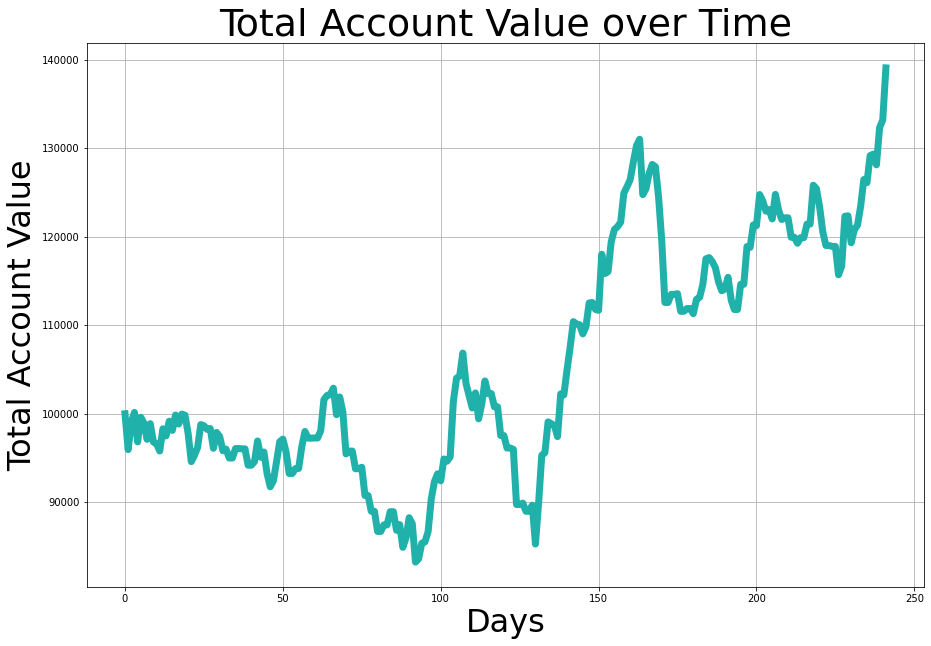

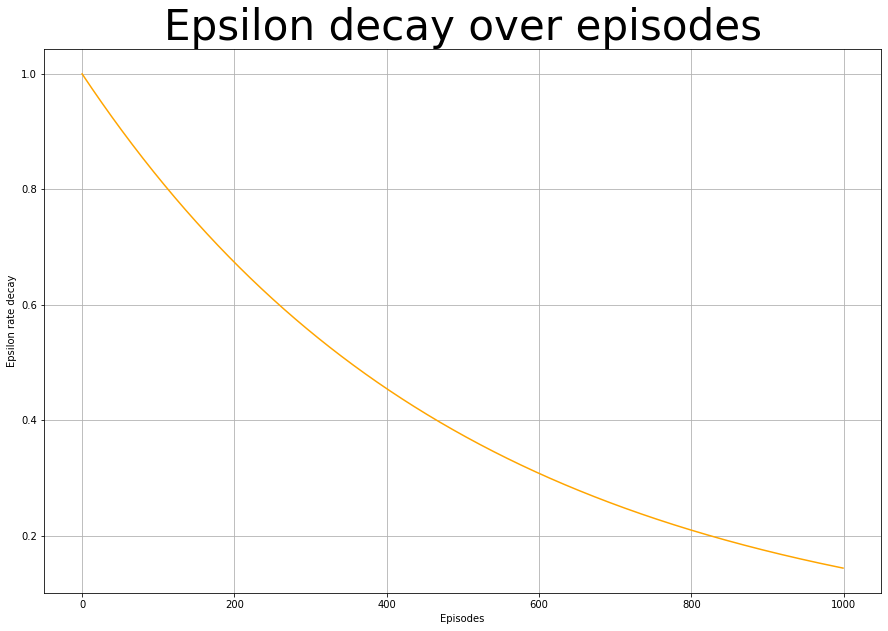

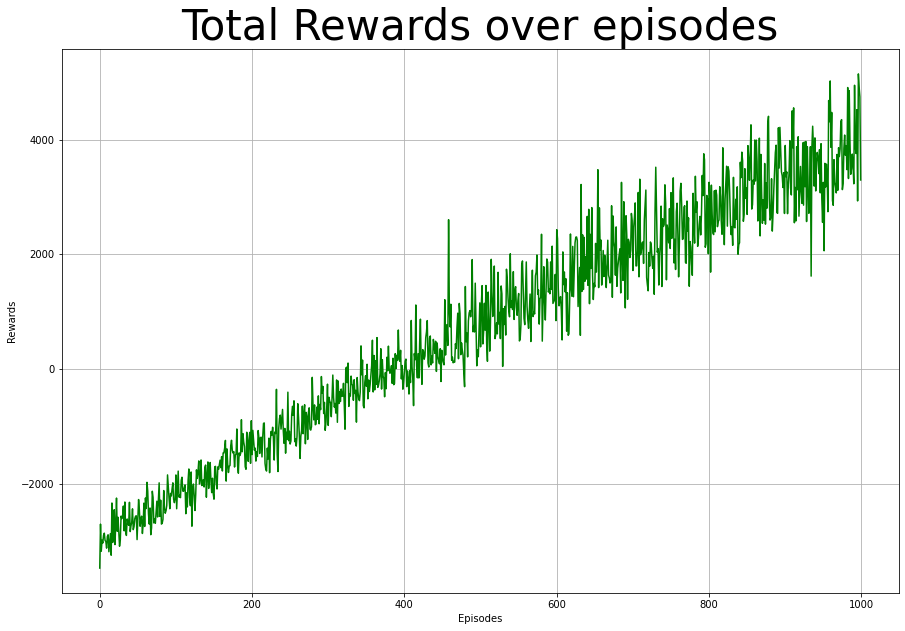

In [222]:
# Training, Testing the Agent and Plotting the Parameters values over the Episodes
q_learning_model.train()
q_learning_model.evaluate()
q_learning_model.plot()